## 1. Import Library

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna.integration.lightgbm as op_lgb
import seaborn as sns
import category_encoders as ce
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix

import utils

## 2. Load data

In [185]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
genre = pd.read_csv("../data/genre_labels.csv")

In [186]:
train = train.dropna().reset_index(drop=True)
train = train.drop(["index"], axis=1)
train

,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,121-152,region_H
1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,153-176,region_I
2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,64-76,region_E
3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,177-192,region_C
4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,97-120,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4031,10,38,246309,0.128795,0.329718,0.575830,-5.252543,0.509531,0.193781,0.187331,0.158197,121-152,region_P
4032,5,23,208734,0.778732,0.228757,0.394283,-14.225700,0.322871,0.253108,0.141218,0.295608,121-152,region_D
4033,10,30,407016,0.402050,0.462374,0.672265,-10.711253,0.646571,0.228189,0.152270,0.163483,97-120,region_E
4034,10,25,204957,0.208096,0.465511,0.523514,-7.855946,0.508910,0.247820,0.202238,0.210184,77-96,region_R


In [187]:
test = test.drop(["index"], axis=1)
test

,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,43,192465,0.559812,0.565035,0.522237,-12.217087,0.620510,0.389727,0.214989,0.161924,77-96,region_I
1,40,226536,0.134002,0.542547,0.493128,-2.612846,0.853089,0.163106,0.184183,0.155460,121-152,unknown
2,58,215385,0.140537,0.643086,0.533189,-3.439684,0.834416,0.429304,0.167352,0.179191,121-152,region_K
3,49,254494,0.266406,0.456733,0.410583,-10.830424,0.534261,0.151830,0.174403,0.186061,77-96,region_D
4,50,230934,0.351907,0.526235,0.645625,-9.099337,0.612474,0.319161,0.157594,0.184142,97-120,region_E
...,...,...,...,...,...,...,...,...,...,...,...,...
4041,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,0.206592,0.198859,121-152,region_B
4042,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,0.205218,0.179438,121-152,region_I
4043,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,0.123748,0.135281,121-152,region_H
4044,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,0.165837,0.162821,121-152,region_B


In [188]:
genre

,genre,labels
0,country,0
1,electronic,1
2,folk,2
3,hip-hop,3
4,jazz,4
5,latin,5
6,classic,6
7,other-light-music,7
8,pop,8
9,religious,9


## 3. 特徴量エンジニアリング
- Features:
    - tempo: tempo_min, tempo_max, tempo_diff
    - region: label encoding (unkown含む)
    - popularity_001: popularityの1の位の値
    - popularity_010: 10の位の値
    - region : regionをkeyにした集約特徴量
- train, valid: 8:2でランダムに分割
- Model: light gbm (パラメータチューニングなし)

In [189]:
def make_tempo_features(df, key="tempo"):
    
    tempo = df.copy()[key]
    
    # min, max
    tempo = tempo.str.split("-", expand=True)
    tempo.columns = ["tempo_min", "tempo_max"]
    tempo = tempo[["tempo_min", "tempo_max"]].astype(int)
    
    # sum
    tempo["tempo_sum"] = tempo["tempo_min"] + tempo["tempo_max"]
    # diff
    tempo["tempo_diff"] = tempo["tempo_max"] - tempo["tempo_min"]
    # mean
    tempo["tempo_mean"] = tempo["tempo_sum"] / 2
    
    return tempo


# def make_region_features(df, key="region"):
    
#     region = df.copy()[key]
#     region = pd.get_dummies(region)
    
#     _df = pd.concat([df, region], axis=1)
#     return _df


def make_popularity_features(df, key="popularity"):
    
    # popularity の10の位と1の位の特徴量
    tmp = df[key].astype(str).str.zfill(2)
    tmp = [[i[0], i[1]] for i in tmp]
    _df = pd.DataFrame(tmp, columns=["popularity10", "popularity01"])
    return _df.astype(int)


def max_min(x):
    return max(x) - min(x)

def q75_q25(x):
    return x.quantile(0.75) - x.quantile(0.25)

def z_score(x):
    return 0.0

# def _make_key_agg(df, key):
    
#     # 前処理
#     if "genre" in df.columns:
#         df = df.drop(["genre"], axis=1)
#     df_columns = df.columns
    
#     # 集約特徴量作成
#     agg_methods = ["min", "mean", "max", "median", "std", max_min, q75_q25, z_score]
#     key_agg = df.groupby(key).agg(agg_methods)

#     # 適切な列名を作成
#     key_agg_columns = []
#     for col in key_agg.columns.levels[0]:
#         for stat in key_agg.columns.levels[1]:
#             key_agg_columns.append(f"agg_{stat}_{col}_groupby_{key}")
#     key_agg.columns = key_agg_columns
    
#     return key_agg
    

def make_agg_region_features(df, key="region"):
    # 前処理
    if "genre" in df.columns:
        df = df.drop(["genre"], axis=1)
    df_columns = df.columns
    
    tempo_features = make_tempo_features(df)[["tempo_min", "tempo_max"]]
    df = pd.concat([make_numerical_features(df), tempo_features, df[key]], axis=1)
    
    # 集約特徴量作成
    agg_methods = ["min", "mean", "max", "median", "std", max_min, q75_q25, z_score]
    key_agg = df.groupby(key).agg(agg_methods)

    # 適切な列名を作成
    key_agg_columns = []
    for col in key_agg.columns.levels[0]:
        for stat in key_agg.columns.levels[1]:
            key_agg_columns.append(f"agg_{stat}_{col}_groupby_{key}")
    key_agg.columns = key_agg_columns
    
    # 出力するdfを作成
    _df = pd.DataFrame({})
    for i, k in enumerate(df[key]):
        if i == 0:
            _df = key_agg.loc[k]
        else:
            _df = pd.concat([_df, key_agg.loc[k]], axis=1)
    _df = _df.T.reset_index(drop=True)
    
    # z_scoreを追加
    i = 0
    for col in _df.columns:
        if "z_score" in col:
            feature_name = df.columns[i]
            _df[col] = (df[feature_name].values - _df[f"agg_mean_{feature_name}_groupby_{key}"].values) / (_df[f"agg_std_{feature_name}_groupby_{key}"].values + 1e-3)
            i += 1
            
    return _df


def make_ce_features(df):
    # count encodingした特徴量
    _df = pd.concat([df, make_popularity_features(df)], axis=1)
    cols = ["region", "popularity10"]
    encoder = ce.CountEncoder()
    return encoder.fit_transform(_df[cols]).add_prefix("CE_")


def make_oe_features(df):
    # ordinal encording (label encoding)した特徴量
    cols = ["region"]
    encoder = ce.OrdinalEncoder()
    return encoder.fit_transform(df[cols]).add_prefix("OE_")


def make_numerical_features(df):
    # そのままの数値特徴
    cols = ['popularity',
            'duration_ms',
            'acousticness',
            'positiveness',
            'danceability',
            'loudness',
            'energy',
            'liveness',
            'speechiness',
            'instrumentalness']
    return df[cols].copy()

In [190]:
def preprocess(df, funcs):
    df_list = [func(df) for func in funcs]
    _df = pd.concat(df_list, axis=1)
    return _df
    

def get_train_data(train, test):
    # each_funcs: trainのみを対象とした処理
    each_funcs = [make_numerical_features,
                  make_tempo_features,
                  make_popularity_features]
    
    # whole_funcs: train+testの全体集合を対象とした処理
    whole_funcs = [make_ce_features,
                   make_oe_features,
                   make_agg_region_features]
    whole_df = pd.concat([train, test]).reset_index(drop=True)
    
    train_out = preprocess(train, each_funcs)
    whole_out = preprocess(whole_df, whole_funcs)
    
    X_train = pd.concat([train_out, whole_out.iloc[:len(train)]], axis=1)
    return X_train

def get_test_data(train, test):
    # each_funcs: testのみを対象とした処理
    each_funcs = [make_numerical_features,
                  make_tempo_features,
                  make_popularity_features]
    
    # whole_funcs: train+testの全体集合を対象とした処理
    whole_funcs = [make_ce_features,
                   make_oe_features,
                   make_agg_region_features]
    whole_df = pd.concat([train, test]).reset_index(drop=True)
    
    test_out = preprocess(test, each_funcs)
    whole_out = preprocess(whole_df, whole_funcs)
    
    X_test = pd.concat([test_out, whole_out.iloc[len(train):].reset_index(drop=True)], axis=1)
    return X_test

In [191]:
# Get train data
X = get_train_data(train.drop(["genre"], axis=1), test)
y = train["genre"]
X

,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,...,agg_q75_q25_tempo_min_groupby_region,agg_z_score_tempo_min_groupby_region,agg_min_tempo_max_groupby_region,agg_mean_tempo_max_groupby_region,agg_max_tempo_max_groupby_region,agg_median_tempo_max_groupby_region,agg_std_tempo_max_groupby_region,agg_max_min_tempo_max_groupby_region,agg_q75_q25_tempo_max_groupby_region,agg_z_score_tempo_max_groupby_region
0,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,...,24.0,0.418657,76.0,134.109091,208.0,152.0,30.246187,132.0,32.0,0.591490
1,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,...,24.0,1.479509,40.0,134.366179,220.0,152.0,31.016197,180.0,32.0,1.342282
2,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,...,24.0,-1.646134,56.0,133.034763,208.0,120.0,29.341873,152.0,32.0,-1.943735
3,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,...,24.0,1.989580,76.0,141.497076,220.0,152.0,30.895721,144.0,32.0,1.634572
4,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,...,24.0,-0.496427,40.0,135.505747,208.0,152.0,29.839040,168.0,32.0,-0.519629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4031,38,246309,0.128795,0.329718,0.575830,-5.252543,0.509531,0.193781,0.187331,0.158197,...,24.0,0.345571,40.0,134.712557,220.0,120.0,31.910751,180.0,32.0,0.541727
4032,23,208734,0.778732,0.228757,0.394283,-14.225700,0.322871,0.253108,0.141218,0.295608,...,24.0,0.188649,63.0,139.669927,208.0,152.0,30.981906,145.0,32.0,0.397964
4033,30,407016,0.402050,0.462374,0.672265,-10.711253,0.646571,0.228189,0.152270,0.163483,...,24.0,-0.433868,56.0,133.034763,208.0,120.0,29.341873,152.0,32.0,-0.444222
4034,25,204957,0.208096,0.465511,0.523514,-7.855946,0.508910,0.247820,0.202238,0.210184,...,24.0,-1.239171,76.0,138.258824,208.0,152.0,31.697661,132.0,32.0,-1.333142


In [199]:
# ハイパーパラメータ設定
params = {
    "task": "train",
    "objective": 'multiclass',
    "num_class": 11,
    "seed": 42,
    "force_row_wise": True,
    "learning_rate": 0.01,
    "verbosity": -1,
#     "boosting_type": "gbdt",
#     "metric": "multi_logloss",
#     "num_leaves": 3,
#     "min_data_in_leaf": 40,
}

# Training model
# Use stratified k fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for cv_num, (train_index, valid_index) in enumerate(kf.split(X, y, y)):
    
    X_train, X_valid = X.loc[train_index].reset_index(drop=True), X.loc[valid_index].reset_index(drop=True)
    y_train, y_valid = y.loc[train_index].reset_index(drop=True), y.loc[valid_index].reset_index(drop=True)
    
    # make dataset
    trains = lgb.Dataset(X_train, label=y_train)
    valids = lgb.Dataset(X_valid, label=y_valid)
    
    # train
    model = lgb.train(params, trains, valid_sets=valids,
                     verbose_eval=False,
                     num_boost_round=10000,
                     early_stopping_rounds=100)
    
    # cv
    y_pred = model.predict(X_valid).argmax(1)
    score = f1_score(y_valid, y_pred, average='macro')
    cv_scores.append(score)
    print(f"Folds: {cv_num}, val_score: {score:.4f}")
    
print(f"Mean-CV-F1Score: {sum(cv_scores) / len(cv_scores): .4f}")

------------------------------ fold 0 ------------------------------
Folds: 0, val_score: 0.5669
------------------------------ fold 1 ------------------------------
Folds: 1, val_score: 0.5819
------------------------------ fold 2 ------------------------------
Folds: 2, val_score: 0.5603
------------------------------ fold 3 ------------------------------
Folds: 3, val_score: 0.5832
------------------------------ fold 4 ------------------------------
Folds: 4, val_score: 0.4934
Mean-CV-F1Score:  0.5572


In [171]:
# Get test data
X_test = get_test_data(train.drop(["genre"], axis=1), test)
y_test = model.predict(X_test).argmax(1)
print(X_test.shape, y_test.shape)

(4046, 116) (4046,)


In [172]:
X_test

,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,...,agg_q75_q25_tempo_min_groupby_region,agg_z_score_tempo_min_groupby_region,agg_min_tempo_max_groupby_region,agg_mean_tempo_max_groupby_region,agg_max_tempo_max_groupby_region,agg_median_tempo_max_groupby_region,agg_std_tempo_max_groupby_region,agg_max_min_tempo_max_groupby_region,agg_q75_q25_tempo_max_groupby_region,agg_z_score_tempo_max_groupby_region
0,43,192465,0.559812,0.565035,0.522237,-12.217087,0.620510,0.389727,0.214989,0.161924,...,24.0,-1.146034,40.0,134.366179,220.0,152.0,31.016197,180.0,32.0,-1.236932
1,40,226536,0.134002,0.542547,0.493128,-2.612846,0.853089,0.163106,0.184183,0.155460,...,24.0,0.361547,40.0,135.505747,208.0,152.0,29.839040,168.0,32.0,0.552756
2,58,215385,0.140537,0.643086,0.533189,-3.439684,0.834416,0.429304,0.167352,0.179191,...,24.0,0.421830,40.0,134.090909,208.0,152.0,29.979175,168.0,32.0,0.597364
3,49,254494,0.266406,0.456733,0.410583,-10.830424,0.534261,0.151830,0.174403,0.186061,...,24.0,-1.281015,63.0,139.669927,208.0,152.0,30.981906,145.0,32.0,-1.409485
4,50,230934,0.351907,0.526235,0.645625,-9.099337,0.612474,0.319161,0.157594,0.184142,...,24.0,-0.433868,56.0,133.034763,208.0,120.0,29.341873,152.0,32.0,-0.444222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,0.206592,0.198859,...,24.0,0.343413,40.0,136.764881,208.0,152.0,28.861168,168.0,32.0,0.527858
4042,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,0.205218,0.179438,...,24.0,0.374017,40.0,134.366179,220.0,152.0,31.016197,180.0,32.0,0.568518
4043,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,0.123748,0.135281,...,24.0,0.418657,76.0,134.109091,208.0,152.0,30.246187,132.0,32.0,0.591490
4044,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,0.165837,0.162821,...,24.0,0.343413,40.0,136.764881,208.0,152.0,28.861168,168.0,32.0,0.527858


## 4. 結果を保存
- F1score(macro) = 0.5564670665812431

In [173]:
# Store csv file
sample_submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit = pd.concat([sample_submit.iloc[:, 0], pd.Series(y_test)], axis=1)

In [174]:
submit

,0,0
0,4046,8
1,4047,10
2,4048,8
3,4049,10
4,4050,8
...,...,...
4041,8087,10
4042,8088,8
4043,8089,1
4044,8090,8


In [175]:
# submit.to_csv("../logs/09_20210426.csv", header=None, index=None)

## 5. 結果の可視化

In [207]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(30,24))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

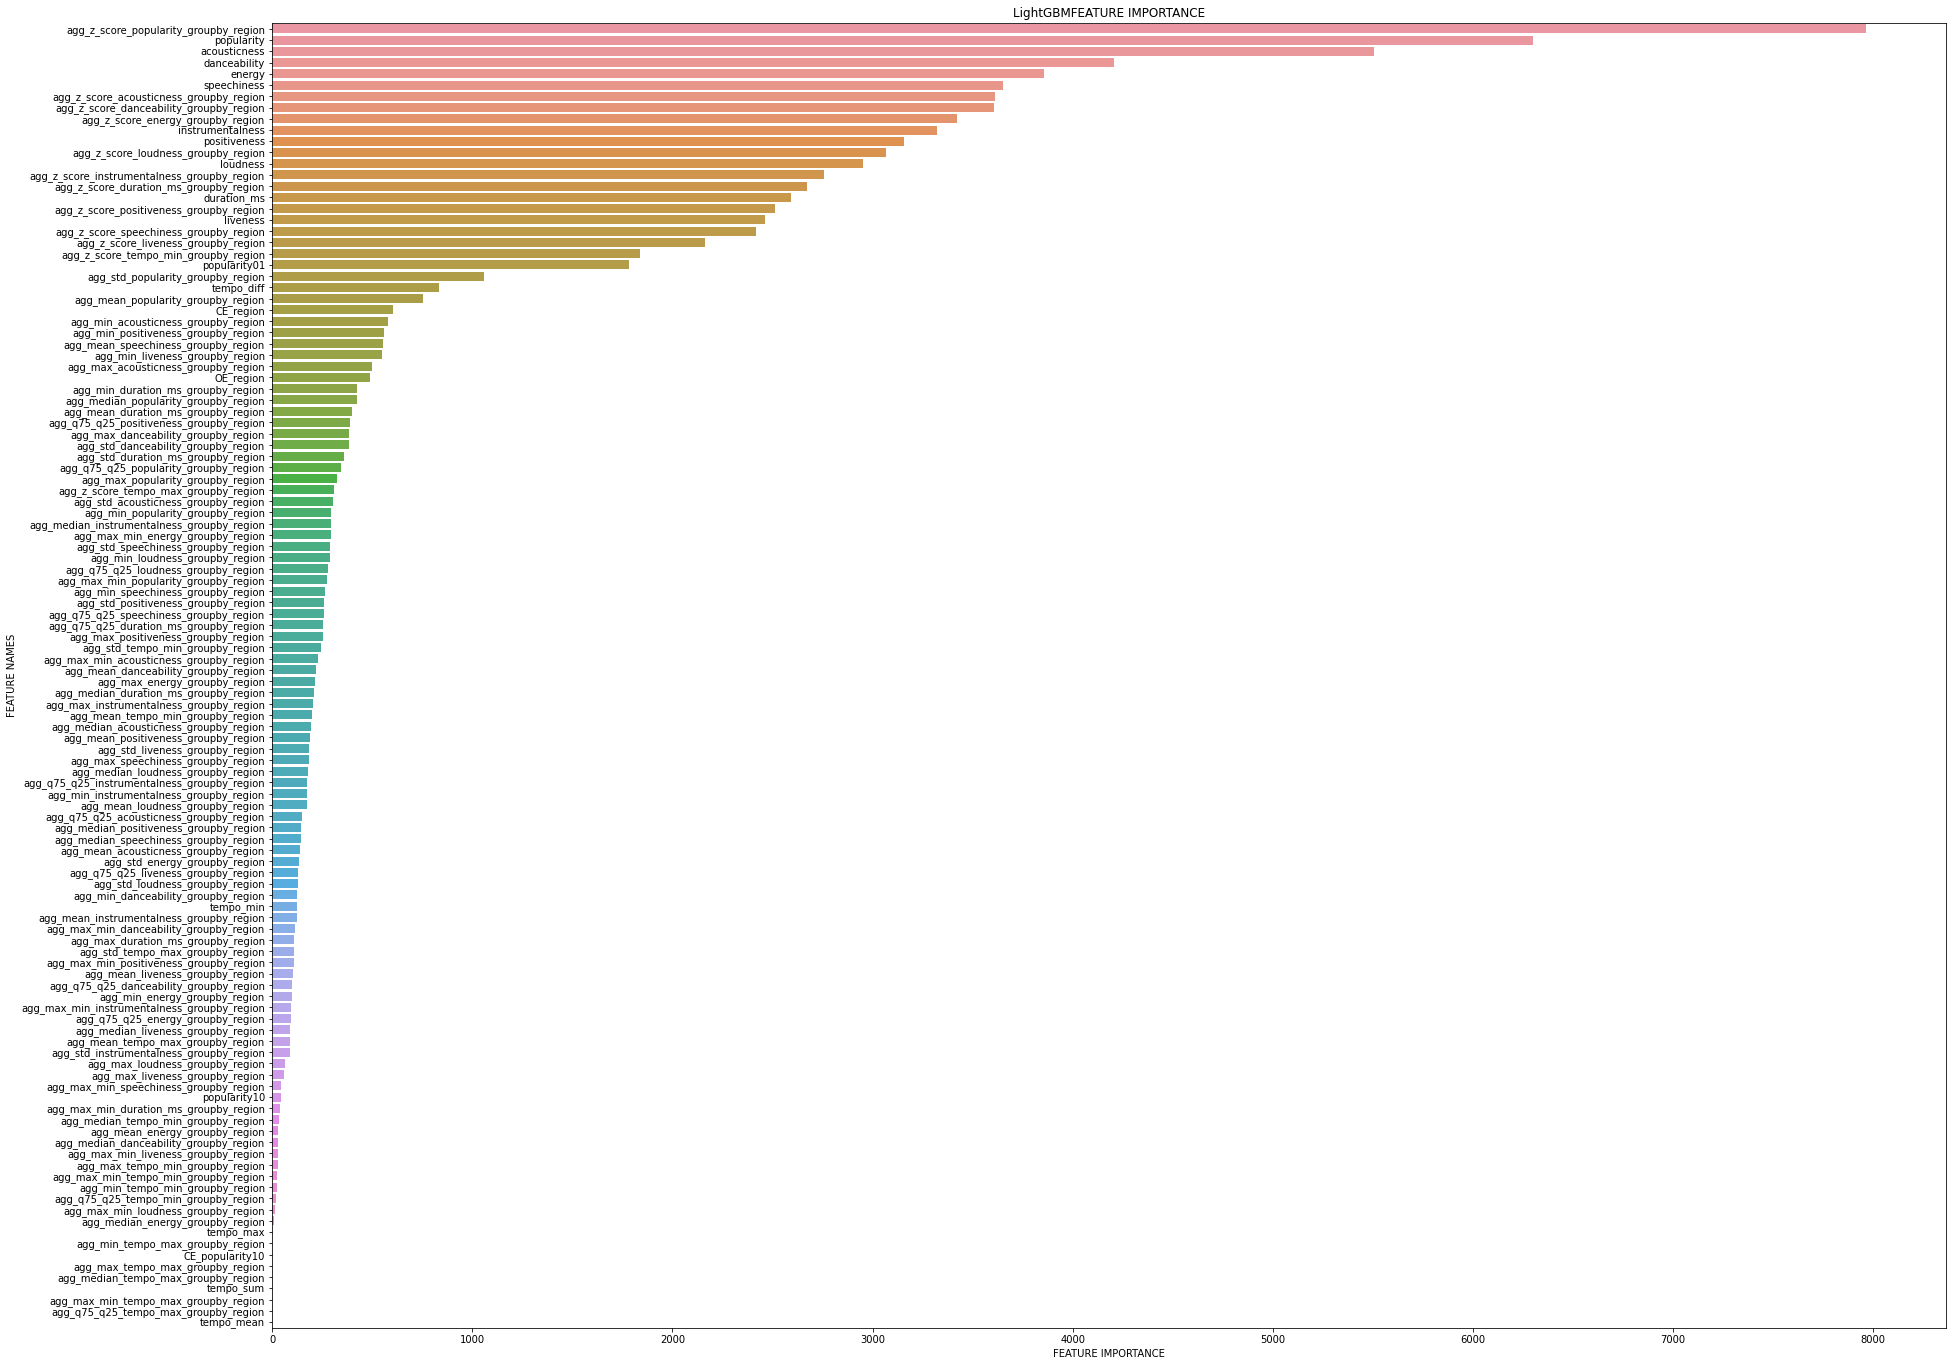

In [208]:
plot_feature_importance(model.feature_importance(), X.columns, "LightGBM")

In [209]:
# feature importanceが0の特徴量
X_train.columns[np.where(model.feature_importance()==0)]

Index(['tempo_max', 'tempo_sum', 'tempo_mean', 'CE_popularity10',
       'agg_min_tempo_max_groupby_region', 'agg_max_tempo_max_groupby_region',
       'agg_median_tempo_max_groupby_region',
       'agg_max_min_tempo_max_groupby_region',
       'agg_q75_q25_tempo_max_groupby_region'],
      dtype='object')

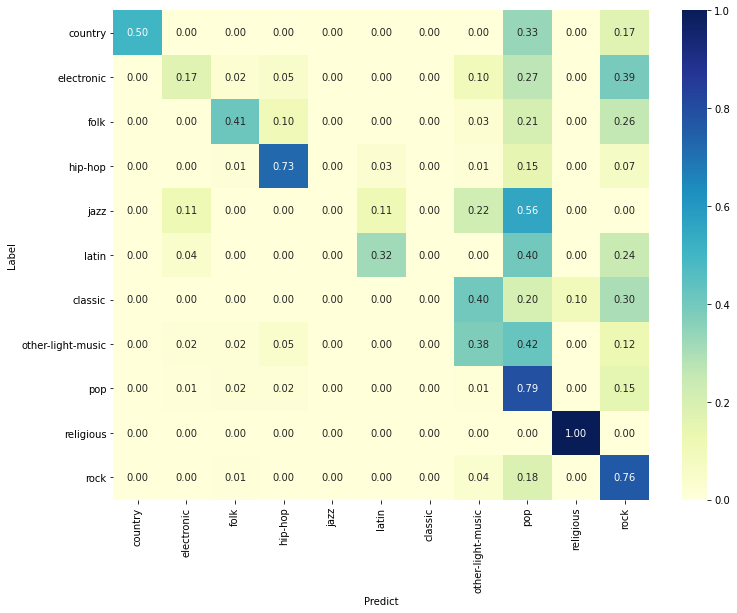

In [178]:
conf = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize="true")
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(conf, cmap='YlGnBu', ax=ax, annot=True, fmt=".2f")
# heatmapの設定
ax.set_ylabel('Label')
ax.set_xlabel('Predict')
genre_labels = genre["genre"]
ax.set_yticklabels(genre_labels)
ax.set_xticklabels(genre_labels)
ax.tick_params('y', labelrotation=0)
ax.tick_params('x', labelrotation=90)